### This notebook serves as an example notebook that demonstrates the basic functionality of the `nimbus` package to generate posterior probabilities for kilonova models, by going through each of the steps outlined in the README of the package repository.

This notebook assumes that users have installed `nimbus` in their current Python environment. This notebook is based on the nimbus package outlined in [Mohite et al. (2021)](https://arxiv.org/abs/2107.07129) and associated data corresponding to the follow-up of the gravitational-wave event GW190425 in [Coughlin et al. (2019)](https://iopscience.iop.org/article/10.3847/2041-8213/ab4ad8) and [Kasliwal et al. (2020)](https://iopscience.iop.org/article/10.3847/1538-4357/abc335). Any comments/suggestions regarding the package can be directed to srmohite@uwm.edu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In order to begin the inference we need to initialize our data inputs. As shown in the README file for this package, we need the following data inputs to get started. We consider the event GW190425 as an example.

For the purposes of this example notebook we only consider follow-up data from 2 fields (`field=420` and `field=584`) to demonstrate the basic functionality of each script.

In [2]:
data_file = 'GW190425_data_file.csv'
samples_file = 'prior_samples.txt'
survey_file = 'ZTF_fields.pkl'
skymap_file = 'GW190425z-LALInference.fits.gz'
t_start = '2019-04-25T08:18:05' # Start time is the merger time of the event.
t_end = '2019-04-28T08:18:05' # We only consider 3 days of follow-up data here.

Let us load and print the data inputs here to get a sense for what the inference expects.

In [3]:
data = pd.read_csv(data_file)
prior_samples = np.loadtxt(samples_file)
survey_data = pd.read_pickle(survey_file)

### Follow-up Data with upper limits

This data file contains the upper limits observed during the survey of the event alongwith other parameters shown below.

In [4]:
data.head()

,jd,field,scimaglim,fid,status
0,2.458599e+06,584,21.28,2,1
1,2.458599e+06,584,21.43,2,1
2,2.458599e+06,584,21.40,2,1
3,2.458599e+06,584,21.48,2,1
4,2.458599e+06,584,21.31,2,1


In [5]:
data.columns

Index(['jd', 'field', 'scimaglim', 'fid', 'status'], dtype='object')

### Prior Samples

The prior samples file contains prior draws of our model parameters that govern the kilonova light curve evolution and those we wish to constrain using the follow-up data above. The prior samples given here are drawn from a uniform distribution for our linear model parameters (see Step 1 below) $M_{0}, \alpha$.

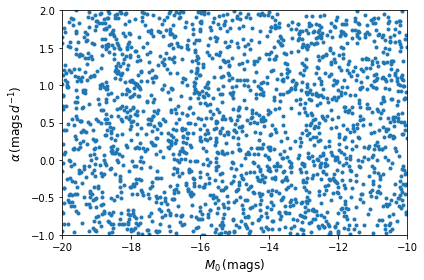

In [6]:
plt.plot(prior_samples[:,0],prior_samples[:,1],'.')
plt.xlabel(r'$M_{0} \, (\mathrm{mags})$',fontsize=12)
plt.ylabel(r'$\alpha \, (\mathrm{mags} \, d^{-1})$',fontsize=12)
plt.xlim(-20,-10)
plt.ylim(-1,2)
plt.tight_layout()

Since the likelihood inference given in Step 1 below is intensive we will restrict ourselves to using only 2 samples to generate representative values in each of the steps below. 

**Note** : The files `infield_likelihood_singleband_420.txt` and `infield_likelihood_singleband_584.txt` already contain the likelihood values generated for the 2000 prior samples shown above. 

In [8]:
#Let us construct a prior sample file containing only 2 samples from above
np.savetxt('two_prior_samples.txt',prior_samples[:2])

### Survey File

The survey file contains specific information about the survey - in particular, as shown below, the RA, Dec of each field, the pixel numbers contained in the field as per the Healpix map convention (`nside=256`) and derived using the `gwemopt`package (https://github.com/mcoughlin/gwemopt), the total extinction values in each of the relevant passbands of the survey (g,r and i for ZTF here) and the line-of-sight extincion E(B-V) for the given field. We make use of the `dustmaps` package ([Green(2018)](https://doi.org/10.21105/joss.00695)) and its implementation of the SFD dustmap ([Schlafly and Finkbeiner(2011)](http://adsabs.harvard.edu/abs/2011ApJ...737..103S)) to derive extinction values.

In [9]:
survey_data.head()

,field_ID,RA,DEC,ipix,A_g,A_r,A_i,ebv
0,1,0.0,-89.05,"[785448, 785533, 785534, 785535, 785616, 78561...",0.481138,0.332849,0.247343,0.126026
1,2,90.0,-89.05,"[785470, 785554, 785555, 785556, 785636, 78563...",0.461328,0.319144,0.237159,0.120837
2,3,180.0,-89.05,"[785492, 785575, 785576, 785577, 785656, 78565...",0.40455,0.279866,0.20797,0.105965
3,4,270.0,-89.05,"[785426, 785512, 785513, 785514, 785596, 78559...",0.509038,0.35215,0.261685,0.133333
4,5,16.36364,-81.85,"[783487, 783637, 783638, 783639, 783785, 78378...",0.392867,0.271784,0.201965,0.102905


Once the data inputs are initialized, we follow the steps and code given outlined in the README to calculate, first, the field specific likelihood values and then combine the data from all the fields.

### Step 1 : Single field inference

The single field inference stage involves calculating the field specific likelihood under the assumption that the event is localized within the field. In general, a given event could have a large number of fields for which there exists follow-up data and this step would need to be implemented in parallel for all those fields. However, we only demonstrate this for 2 fields (as defined above) as an example and for computational ease.

We make use of the script `singlefield_calc`. By default this script assumes the inference is for multiple passband filters (3 in this case). The script also assumes that the kilonova luminosity (mags) evolution model is linear in time and is defined by only two parameters $M_{0}, \alpha$ which are the initial brightness and decay/rise slope respectively. Thus, the prior sample file above also contains prior draws corresponding to these two parameters.

    def lc_model_linear(M0, alpha, t_0, t):
        return M0 + alpha*(t-t_0)
        
If users need to change either of these aspects they would need to modify the script appropriately. Note : The script does have an option called `single_band` to model the luminosity evolution across a single (combined) passband filter.

The command-line implementation of this script, for `field=584` and the data above would be (as given in the README):

    singlefield_calc --field=584 --data_file GW190425_data_file.csv --survey_file ZTF_fields.pkl --skymap_file GW190425z-LALInference.fits.gz --sample_file two_prior_samples.txt --t_start 2019-04-25T08:18:05 --t_end 2019-04-28T08:18:05 --output_str infield_likelihood_example_ --single_band
 
This will produce an output file named `infield_likelihood_singleband_584.txt` that contains likelihood values corresponding to each prior sample in the `sample_file`. 

In [10]:
!singlefield_calc --field=584 --data_file GW190425_data_file.csv --survey_file ZTF_fields.pkl --skymap_file GW190425z-LALInference.fits.gz --sample_file two_prior_samples.txt --t_start 2019-04-25T08:18:05 --t_end 2019-04-28T08:18:05 --output_str infield_likelihood_example_ --single_band

Ingesting skymap:GW190425z-LALInference.fits.gz
Initializing inference framework...


In [11]:
!singlefield_calc --field=420 --data_file GW190425_data_file.csv --survey_file ZTF_fields.pkl --skymap_file GW190425z-LALInference.fits.gz --sample_file two_prior_samples.txt --t_start 2019-04-25T08:18:05 --t_end 2019-04-28T08:18:05 --output_str infield_likelihood_example_ --single_band

Ingesting skymap:GW190425z-LALInference.fits.gz
Initializing inference framework...


In [12]:
likelihood_420 = np.loadtxt('infield_likelihood_singleband_420.txt')
likelihood_584 = np.loadtxt('infield_likelihood_singleband_584.txt')

In [16]:
# We can check that the script above generates the same values as expected by comparing the two files
np.loadtxt('infield_likelihood_example_584.txt'),likelihood_584[:2]

(array([0.     , 0.01695]), array([0.        , 0.01694902]))

Let us plot these likelihood values against the prior samples.

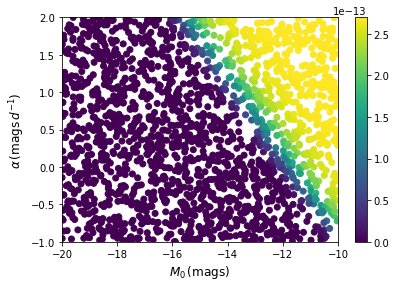

In [23]:
plt.scatter(prior_samples[:,0],prior_samples[:,1],c=likelihood_420)
plt.xlabel(r'$M_{0} \, (\mathrm{mags})$',fontsize=12)
plt.ylabel(r'$\alpha \, (\mathrm{mags} \, d^{-1})$',fontsize=12)
plt.xlim(-20,-10)
plt.ylim(-1,2)
plt.tight_layout()
plt.colorbar()

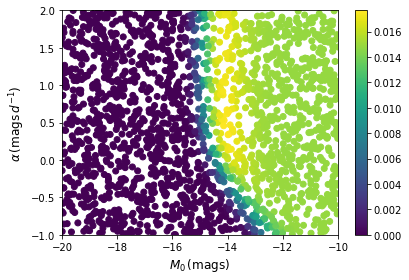

In [24]:
plt.scatter(prior_samples[:,0],prior_samples[:,1],c=likelihood_584)
plt.xlabel(r'$M_{0} \, (\mathrm{mags})$',fontsize=12)
plt.ylabel(r'$\alpha \, (\mathrm{mags} \, d^{-1})$',fontsize=12)
plt.xlim(-20,-10)
plt.ylim(-1,2)
plt.tight_layout()
plt.colorbar()

### Step 2 : Compute field probabilities

Once the likelihood values for all fields have been computed, we need to compute the probability that the event is in each field in order to combine the results from multiple fields. This is done with the help of the `compute_field_probs` script using the `survey_file`, `skymap_file` for the event and the likelihood files produced above. In this case the implementation would be:

    compute_field_probs --field_probs_file field_probs.txt --survey_file ZTF_fields.pkl --skymap_file GW190425z-LALInference.fits.gz --infield_likelihoods_path=./infield_likelihood*.txt --common_str=infield_likelihood_singleband_
    
This will produce an output file named `field_probs.txt` that contains the event localization probabilities (stored in order) for every field that has a likelihood calculation associated with it.

In [18]:
!compute_field_probs --field_probs_file field_probs.txt --survey_file ZTF_fields.pkl --skymap_file GW190425z-LALInference.fits.gz --infield_likelihoods_path=./infield_likelihood_example*.txt --common_str=infield_likelihood_example_

Ingesting skymap:GW190425z-LALInference.fits.gz


In [19]:
# We can print the field probabilites to check this
np.loadtxt('field_probs.txt')

array([2.69807624e-13, 1.48859723e-02])

### Step 3 : Combine field likelihoods

The final step in the inference is to combine the individual field likelihoods and field probabilites from Steps 1 and 2 to give us the log-likelihood (natural log) values for each hyperparameter sample. This is done using the `combine_fields` executable.

    combine_fields --sample_file prior_samples.txt --field_probs_file field_probs.txt --infield_likelihoods_str infield_likelihood_singleband_ --P_A 0.999 --output_file GW190425_samples_likelihood.txt
    
This will produce the final data product file containing the model/hyper-parameter samples as well the combined log-likelihood values for each corresponding sample.

In [20]:
!combine_fields --sample_file prior_samples.txt --field_probs_file field_probs.txt --infield_likelihoods_str infield_likelihood_singleband_ --P_A 0.999 --output_file GW190425_samples_likelihood.txt

Let us plot the combined likelihood from these 2 fields. 

**Note** : The actual combined calculation would contain contributions from several fields. This visualization is only for the purposes of an example.

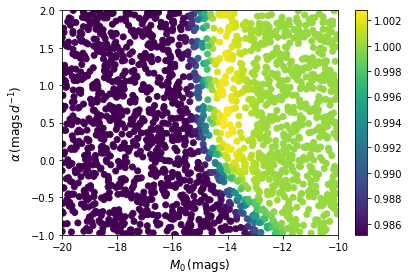

In [23]:
combined_logl = np.loadtxt('GW190425_samples_likelihood.txt')[:,2]

plt.scatter(prior_samples[:,0],prior_samples[:,1],c=np.e**combined_logl)
plt.xlabel(r'$M_{0} \, (\mathrm{mags})$',fontsize=12)
plt.ylabel(r'$\alpha \, (\mathrm{mags} \, d^{-1})$',fontsize=12)
plt.xlim(-20,-10)
plt.ylim(-1,2)
plt.tight_layout()
plt.colorbar()